In [ ]:
# # install libraries
# !pip install WordCloud
# !pip install keras
# !pip install tensorflow
# !pip install xgboost

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import html
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# read the twitter data into dataframe
election_df=pd.read_csv('Canadian_elections_2019.csv',encoding="utf8")
sentiment_df=pd.read_csv('sentiment_analysis.csv',encoding='utf-8')

# Data Cleaning
Strings collected from web are usually very "dirty" and they contain different kinds of structures like HTML tags, URLs, Unicodes, etc. To better process the data and produce meaeningful result, the strings need to be cleaned so that the useful information is more obvious in each string. The following steps are performed to preprocess the tweeter data in both files:


*   Remove all HTML tags
*   HTML character codes replaced by ASCII equivalent
*   Remove \n
*   Remove unicode in \\xxx pattern
*   Remove unicode in #xxx pattern
*   Remove URLs
*   Remove special characters except '@' and '#'
*   Lower casing
*   Tokenize each tweet
*   Remove stopwords using NLTK's stopwords



## **Text preprocessing for election tweets**




In addition to the data cleaning process above, the hashtag and mentioned text were extracted to prepare for the exploratory analysis. Also, the first character 'b' in each tweet was removed to get the body of each tweet.

In [ ]:
# remove all html tags
clean_text=[re.sub('<[^>]+>',' ',x) for x in election_df['text']]
# replace html character code with ASCII equivalent
clean_text=[html.unescape(x) for x in clean_text]
# remove \n
clean_text=[re.sub(r'\\n',' ',x) for x in clean_text]
# remove unicode in \xxx format
clean_text=[re.sub(r'\\x..','',x) for x in clean_text]
# remove unicode in #xxx format
clean_text=[re.sub(r'#x..','',x) for x in clean_text]
# remove URLs
clean_text=[re.sub(r'https?://\S+|www\.\S+',' ',x) for x in clean_text]
# remove special characters except '@' and '#'
clean_text=[re.sub('[^A-Za-z0-9@#]+', ' ', x) for x in clean_text]
# lower casing
lower_text=[x.lower() for x in clean_text]
# tokenize each tweet
text_token=[x.split() for x in lower_text]
# remove first character 'b'
text_token=[x[1:] for x in text_token]
# get stopword
nltk_stopwords=stopwords.words('english')
# empty list to store the result
filtered_token=[]
# for each tweet
for sentence in text_token:
    filtered_sentence=[]
    # for each word
    for word in sentence:
        # if the word is not a stopword
        if word not in nltk_stopwords:
            # append the word to the list
            filtered_sentence.append(word)
    # append filtered word to the result list
    filtered_token.append(filtered_sentence)

In [ ]:
# add the result of preprocessing to the original dataframe
election_df['preprocessed']=filtered_token

In [ ]:
# create empty list to store hashtags and mentioned
mentioned=[]
hashtag=[]
# iterate through each tweet
for tweet in election_df['preprocessed']:
    user_mentioned=[]
    # if the word has '@' and the word has not been added to the user_mentioned list
    for word in tweet:
        if '@' in word:
            if word not in user_mentioned:
                # append the word without the '@'
                user_mentioned.append(word[1:])
    # append the user_mentioned list to the result
    mentioned.append(user_mentioned)
# iterate through each tweet
for tweet in election_df['preprocessed']:
    user_hashtag=[]
    # if the word has '#' and the word has not been added to the user_mentioned list
    for word in tweet:
        if '#' in word:
            if word not in user_hashtag:
                # append the word without the '#'
                user_hashtag.append(word[1:])
    # append the user_hashtag list to the result
    hashtag.append(user_hashtag)

In [ ]:
# add the result to the dataframe
election_df['mentioned']=mentioned
election_df['hashtag']=hashtag

In [ ]:
# remove mentioned and hashtag from preprocessed token
cleaned_list=[]
for tweet in election_df['preprocessed']:
    cleaned_tweet=[]
    for token in tweet:
        if ('@' not in token) & ('#' not in token):
            cleaned_tweet.append(token)
    cleaned_list.append(cleaned_tweet)
election_df['preprocessed']=cleaned_list

## **Text preprocessing for generic tweets**

In addition to the basic data preprocessing steps, the hashtag and mentioned text were removed so only the meaningful body of tweets were remained. By doing this, the relation between each user and mentioned user will be ignored and the subject of each tweet will be removed, but the purpose of this task is to analyze the sentiment of tweets, therefore the relation between users and the subject of each tweet is not that important. Also, if 'RT' appears in the tweet, it will be removed to get the body of each tweet.

In [ ]:
# remove all html tags
clean_text=[re.sub('<[^>]+>',' ',x) for x in sentiment_df['text']]
# replace html character code with ASCII equivalent
clean_text=[html.unescape(x) for x in clean_text]
# remove \n
clean_text=[re.sub(r'\\n',' ',x) for x in clean_text]
# remove unicode in \xxx format
clean_text=[re.sub(r'\\x..','',x) for x in clean_text]
# remove unicode in #xxx format
clean_text=[re.sub(r'#x..','',x) for x in clean_text]
# remove URLs
clean_text=[re.sub(r'https?://\S+|www\.\S+',' ',x) for x in clean_text]
# remove special characters except '@' and '#'
clean_text=[re.sub('[^A-Za-z0-9@#]+', ' ', x) for x in clean_text]
# lower casing
lower_text=[x.lower() for x in clean_text]
# tokenize each tweet
text_token=[x.split() for x in lower_text]
# get stopword
nltk_stopwords=stopwords.words('english')
# empty list to store the result
filtered_token=[]
# for each tweet
for sentence in text_token:
    filtered_sentence=[]
    # for each word
    for word in sentence:
        # if the word is not a stopword and not 'rt'
        if (word not in nltk_stopwords) & (word != 'rt'):
            # append the word to the list
            filtered_sentence.append(word)
    # append filtered word to the result list
    filtered_token.append(filtered_sentence)

In [ ]:
# add the result of preprocessing to the original dataframe
sentiment_df['preprocessed']=filtered_token

In [ ]:
# remove mentioned and hashtag from preprocessed token
cleaned_list=[]
for tweet in sentiment_df['preprocessed']:
    cleaned_tweet=[]
    for token in tweet:
        if ('@' not in token) & ('#' not in token):
            cleaned_tweet.append(token)
    cleaned_list.append(cleaned_tweet)
sentiment_df['preprocessed']=cleaned_list

# Exploratory analysis

## **Identify political party for election tweets**

1. Using hashtag to identify political party

    If a tweet's hashtag has the party's name or the abbreviation of the party or the leader of the party, then the tweet's political party will be assigned to that party.


2. Using tweets as supplement for the result obtained using hashtag

    Some users might demonstrate their political leaning in tweets but not in the hashtags. If the tweet has the party's name or the abbreviation of the party or the learder of the party, then the tweet's potential political party will be assigned to that party. The result from this step will be the supplement of the first step.

    





In [ ]:
# use hashtag to find political party
political_party=[]
# iterate through each user's hashtag
for h in hashtag:
    # default result is unkown
    result='Unkown'
    # iterate through each tag and assign political party to result based on conditions
    for tag in h:
        if ('liberal' in tag)| ('lpc' in tag) | ('trudeau' in tag):
            result='Liberal'
        elif ('conservative' in tag) | ('cpc' in tag) | ('scheer' in tag):
            result='Conservatives'
        elif ('democratic' in tag) | ('ndp' in tag) | ('singh' in tag):
            result='NDP'
    # append result for the user
    political_party.append(result)
# use tweet to find potential political party
potential_political_party=[]
# iterate through each tweet
for tweet in election_df['preprocessed']:
    # append result to the list based on conditions
    if ('liberal' in tweet) | ('lpc' in tweet) | ('trudeau' in tweet):
        potential_political_party.append('Liberal')
    elif ('conservative' in tweet) | ('cpc' in tweet) | ('scheer' in tweet):
        potential_political_party.append('Conservatives')
    elif ('democratic' in tweet) | ('ndp' in tweet) | ('singh' in tweet):
        potential_political_party.append('NDP')
    else:
        potential_political_party.append('Unkown')
# combine the result from hastag and tweets
for i in range(len(political_party)):
    # if the political party is unkown using hashtag and the potential political party from tweet is not unkown then use the potential political party
    if political_party[i] == 'Unkown':
        if potential_political_party[i] != 'Unkown':
            political_party[i]=potential_political_party[i]
# add political party result to the dataframe
election_df['political_party']=political_party
        

## **Distribution of political affiliation**

From the plot, most tweets don't have specific political affiliation, even though they are talking about politics, most of them don't specify which party they support or talk about and some of the tweets are talking about other parties. In the tweets that have clear subject of political party, Conservatives has the highest number of tweets, then it is Liberal and NDP has lowest number of tweets. 

Text(0.5, 1.0, 'Count of tweet for each political party')

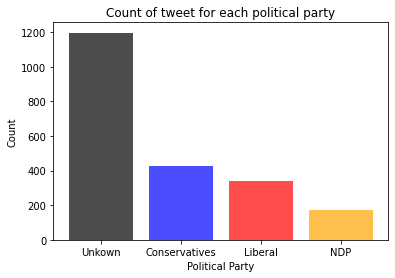

In [ ]:
# get the count for political party
political_party_counts=election_df['political_party'].value_counts()
# plot a bar plot for the count of each political party
plt.bar(height=political_party_counts.values,x=political_party_counts.index,color=['black','blue','red','orange'],alpha=0.7)
plt.xlabel('Political Party')
plt.ylabel('Count')
plt.title('Count of tweet for each political party')

## **Visualize generic tweets and Canadian election tweets**

(-0.5, 3999.5, 2999.5, -0.5)

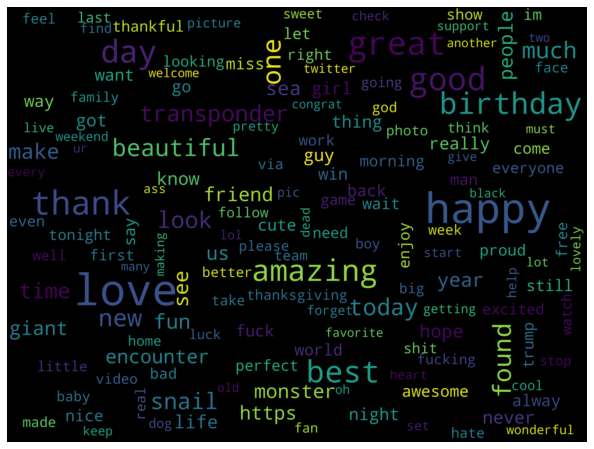

In [ ]:
# create a word cloud for generic tweets
cleaned_generic_tweet=' '.join(' '.join(token) for token in sentiment_df['preprocessed'])
word_cloud = WordCloud(max_font_size=300,max_words=150,width = 4000, height = 3000,collocations=False).generate(cleaned_generic_tweet)
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

(-0.5, 3999.5, 2999.5, -0.5)

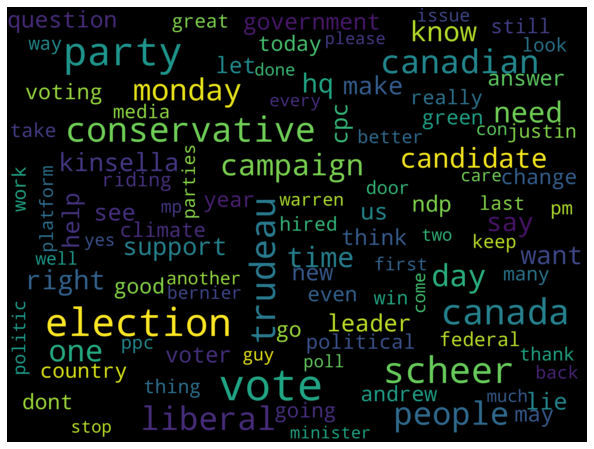

In [ ]:
# create a word cloud for Canadian election tweets
cleaned_election_tweet=' '.join(' '.join(token) for token in election_df['preprocessed'])
word_cloud = WordCloud(max_font_size=300,max_words=100,width = 4000, height = 3000,collocations=False).generate(cleaned_election_tweet)
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

By comparing the two wordclouds from different twitter data, the common words in generic tweets do not have a clear subject and they are all general words that people will use in daily life, also there is a large number of words which shows clear sentiment, like amazing, good, love, etc. However for wordcloud of election tweets, the common words are related to the election or political subjects, and most of the words do not show any sentiment, which means the nature of generic tweets and election tweets are different.



## **Bonus: Number of times each leader was mentioned**

From the plot, the leader of Conservatives was mentioned the most, then it is the leader of Liberal party, the lowest is the leader of NDP. Although not always the tweet is supporting the mentioned leader, the plot does show Andrew Scheer and Justin Trudeau attract the most attention in the election.

Text(0.5, 1.0, 'Number of time each leader was mentioned')

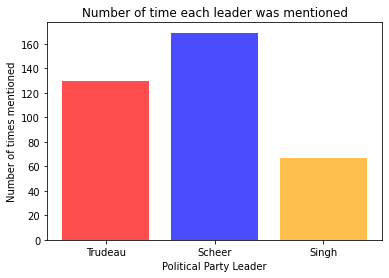

In [ ]:
# find number of times each leader was mentioned
result={'Trudeau':0,'Scheer':0,'Singh':0}
for m in mentioned:
    for mention in m:
        if mention == 'justintrudeau':
            result['Trudeau']+=1
        elif mention == 'andrewscheer':
            result['Scheer']+=1
        elif mention == 'thejagmeetsingh':
            result['Singh']+=1
# visualize the result
plt.bar(height=result.values(),x=result.keys(),color=['red','blue','orange'],alpha=0.7)
plt.xlabel('Political Party Leader')
plt.ylabel('Number of times mentioned')
plt.title('Number of time each leader was mentioned')



## **Bonus: Sentiment fraction for election tweets and generic  tweets**

By comparing the two plots, it is obvious that in generic tweets a majority of people has positive sentiment while in election related tweets people have more negative attitude than usual.

Text(0.5, 1.0, 'Sentiment fraction for generic tweets')

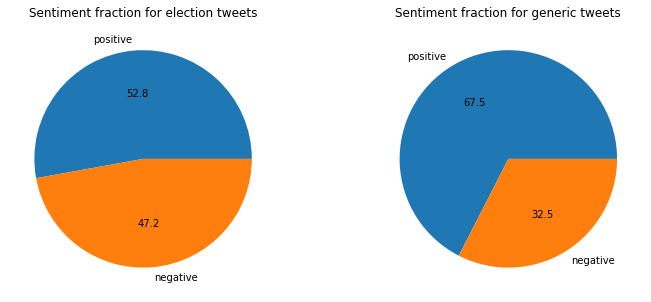

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(12,5))
# pie plot of sentiment fraction for election tweets
election_sentiment=election_df['sentiment'].value_counts()
axs[0].pie(election_sentiment,labels=election_sentiment.keys(),autopct='%.1f')
axs[0].set_title('Sentiment fraction for election tweets')
# pie plot of sentiment fraction for generic tweets
generic_sentiment=sentiment_df['label'].value_counts()
axs[1].pie(generic_sentiment,labels=['positive','negative'],autopct='%.1f')
axs[1].set_title('Sentiment fraction for generic tweets')

# Model preparation

The preprocessed generic tweet is split into training set and test set. Then the CountVectorizer model and TfidfVectorizer model will fit the training set and transform both training and test set into corresponding features, the maximum feature of each vectorizer is set to be 500 to reduce the computational complexity and memory usage (session will crash when using more features).

In [ ]:
# combine tokens to a text
preprocessed_text=[]
for t in sentiment_df['preprocessed']:
    text=' '.join(t)
    preprocessed_text.append(text)
# extract target from dataframe
target=sentiment_df['label']

In [ ]:
# split data into train and test set
X_train,X_test,y_train,y_test=train_test_split(preprocessed_text,target,test_size=0.3,random_state=0)

In [ ]:
# use count vectorizer to transform text
count_vectorizer=CountVectorizer(max_features=500)
# fit the model with training data
count_vectorizer.fit(X_train)
# transform both training data and testing data using trained model
X_train_count=count_vectorizer.transform(X_train)
X_test_count=count_vectorizer.transform(X_test)

In [ ]:
# use TFIDF vectorizer to transform text
tfidf_vectorizer=TfidfVectorizer(max_features=500)
# fit the model with training data
tfidf_vectorizer.fit(X_train)
# transform both training data and testing data using trained model
X_train_tfidf=tfidf_vectorizer.transform(X_train)
X_test_tfidf=tfidf_vectorizer.transform(X_test)

# Model implementation and tuning

Part1: Two dictionaries are used to store the accuracy result from each model with term frequency and TFIDF feature. Each model is trained using training set and the trained model is used to predict the test set. The accuracy score is calcualted using the prediction and true lable of test set. The best model is found using the accuracy score from both dictionary. Then the best model is applied on the Canadian Election tweet. Before that, the Canadian Election tweet is transformed using the best model's corresponding feature with the vectorizer that is trained using generic tweets.

part2: The Canadian Election  tweets with only negative sentiment are extracted. The negative reasons are encoded to numerical value as the target for multi-class classification model .Logistic Regression, Naive Bayes and KNN are used as the multiclass classification model. The hyperparameters of each model is tuned using 5-fold cross-validation. Then the best model is trained with all training data and used to predict the test data. 

## **Part 1: predict sentiment for Canadian Election tweets**

In [ ]:
# create empty dictionary to store result
accuracy_with_count={}
accuracy_with_tfidf={}

Logistic Regression

In [ ]:
# Logistic Regression with word frequency
lr=LogisticRegression(max_iter=200,solver='newton-cg')
lr.fit(X_train_count,y_train)
prediction=lr.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['lr']=accuracy
# store the trained model
lr_count=pickle.dumps(lr)

In [ ]:
# Logistic Regression with TFIDF
lr=LogisticRegression(max_iter=200,solver='newton-cg')
lr.fit(X_train_tfidf,y_train)
prediction=lr.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['lr']=accuracy
# store the trained model
lr_tfidf=pickle.dumps(lr)

KNN

In [ ]:
# KNN with word frequency
knn=KNeighborsClassifier()
knn.fit(X_train_count,y_train)
prediction=knn.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['knn']=accuracy
# store the trained model
knn_count=pickle.dumps(knn)

In [ ]:
# KNN with TFIDF
knn=KNeighborsClassifier()
knn.fit(X_train_tfidf,y_train)
prediction=knn.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['knn']=accuracy
# store the trained model
knn_tfidf=pickle.dumps(knn)

Naive Bayes

In [ ]:
# Naive Bayes with word frequency
nb=MultinomialNB()
nb.fit(X_train_count,y_train)
prediction=nb.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['nb']=accuracy
# store the trained model
nb_count=pickle.dumps(nb)

In [ ]:
# Naive Bayes with TFIDF
nb=MultinomialNB()
nb.fit(X_train_tfidf,y_train)
prediction=nb.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['nb']=accuracy
# store the trained model
nb_tfidf=pickle.dumps(nb)

SVM

In [ ]:
# SVC with word frequency
svc=LinearSVC(max_iter=2000)
svc.fit(X_train_count,y_train)
prediction=svc.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['svc']=accuracy
# store the trained model
svc_count=pickle.dumps(svc)

In [ ]:
# SVC with TFIDF
svc=LinearSVC(max_iter=2000)
svc.fit(X_train_tfidf,y_train)
prediction=svc.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['svc']=accuracy
# store the trained model
svc_tfidf=pickle.dumps(svc)

Decision Tree

In [ ]:
# Decision tree with word frequency
dt=DecisionTreeClassifier(max_depth=50)
dt.fit(X_train_count,y_train)
prediction=dt.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['dt']=accuracy
# store the trained model
dt_count=pickle.dumps(dt)

In [ ]:
# Decision tree with TFIDF
dt=DecisionTreeClassifier(max_depth=50)
dt.fit(X_train_tfidf,y_train)
prediction=dt.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['dt']=accuracy
# store the trained model
dt_tfidf=pickle.dumps(dt)

Random Forest

In [ ]:
# Random forest with word frequency
rf=RandomForestClassifier(max_depth=50)
rf.fit(X_train_count,y_train)
prediction=rf.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['rf']=accuracy
# store the trained model
rf_count=pickle.dumps(rf)

In [ ]:
# Random forest with TFIDF
rf=RandomForestClassifier(max_depth=50)
rf.fit(X_train_tfidf,y_train)
prediction=rf.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['rf']=accuracy
# store the trained model
rf_count=pickle.dumps(rf)

XGBoost

In [ ]:
# Gradient boosting with word frequency
gbc=XGBClassifier()
gbc.fit(X_train_count,y_train)
prediction=gbc.predict(X_test_count)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_count['xgb']=accuracy
# store the trained model
gbc_count=pickle.dumps(gbc)

In [ ]:
# Gradient boosting with TFIDF
gbc=XGBClassifier()
gbc.fit(X_train_tfidf,y_train)
prediction=gbc.predict(X_test_tfidf)
accuracy=accuracy_score(y_test,prediction)
accuracy_with_tfidf['xgb']=accuracy
# store the trained model
gbc_tfidf=pickle.dumps(gbc)

In [ ]:
print('Best model with word frequency: ',max(accuracy_with_count,key=accuracy_with_count.get))

Best model with word frequency:  lr


In [ ]:
print('Best model with TFIDF: ',max(accuracy_with_tfidf,key=accuracy_with_tfidf.get))

Best model with TFIDF:  svc


In [ ]:
if accuracy_with_count['lr'] > accuracy_with_tfidf['svc']:
    print('Best model: Logistic Regression with Term Frequency')
else:
    print('Best model: SVC with TFIDF')

Best model: Logistic Regression with Term Frequency


In [ ]:
# accuracy for best model
print('Accuracy of best model: {}'.format(round(accuracy_with_count['lr'],4)))

Accuracy of best model: 0.9163


**Feature importance of best model**

In [ ]:
# load best model
best_model=pickle.loads(lr_count)
# get the absolute coefficient
abs_coefs=np.abs(best_model.coef_)
# sort the absolute value of coefficient 
sorted_index=np.argsort(abs_coefs)[0][::-1]
# get the index of top 20 feature
top_20_index=sorted_index[:20]
# get feature names from count_vectorizer
feature_name=np.array(count_vectorizer.get_feature_names())
# get top 20 feature names
top_20_feature=feature_name[top_20_index]
# get top 20 feature values
top_20_value=abs_coefs[0][top_20_index]

Text(0.5, 1.0, 'Feature importance in Logistic Regression with term frequency')

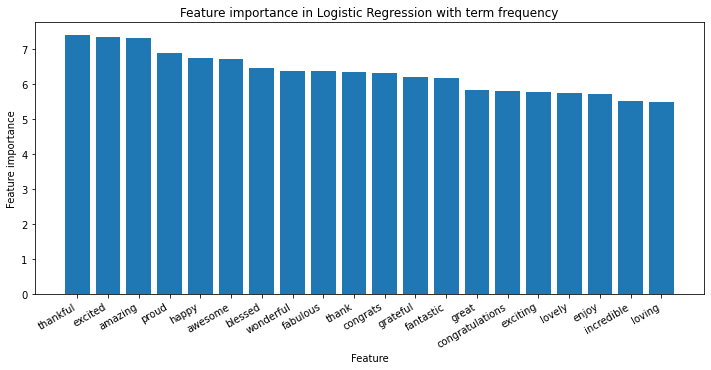

In [ ]:
# create bar plot for feature importance
plt.figure(figsize=(12,5))
plt.bar(height=top_20_value,x=top_20_feature)
plt.xticks(rotation=30,ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature importance')
plt.title('Feature importance in Logistic Regression with term frequency')

## **Bonus: Neural Network with term frequency and TFIDF**

In [ ]:
# nueral network with word frequency
# convert the data to dense 
training_data=X_train_count.todense()
testing_data=X_test_count.todense()
# define the model
model=Sequential()
model.add(Dense(8, input_dim=500, activation='relu'))
model.add(Dense(3,  activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model 
model.fit(training_data, y_train, epochs=10, batch_size=5000)
# evaluate the keras model
_, accuracy = model.evaluate(testing_data, y_test)

Epoch 1/10
78/78 [==============================] - 2s 19ms/step - loss: 0.6650 - accuracy: 0.6577
Epoch 2/10
78/78 [==============================] - 1s 19ms/step - loss: 0.5612 - accuracy: 0.6741
Epoch 3/10
78/78 [==============================] - 1s 19ms/step - loss: 0.4924 - accuracy: 0.6753
Epoch 4/10
78/78 [==============================] - 1s 19ms/step - loss: 0.4535 - accuracy: 0.6740
Epoch 5/10
78/78 [==============================] - 2s 19ms/step - loss: 0.4325 - accuracy: 0.6758
Epoch 6/10
78/78 [==============================] - 2s 20ms/step - loss: 0.4225 - accuracy: 0.7543
Epoch 7/10
78/78 [==============================] - 2s 20ms/step - loss: 0.4144 - accuracy: 0.7665
Epoch 8/10
78/78 [==============================] - 2s 20ms/step - loss: 0.4116 - accuracy: 0.7679
Epoch 9/10
78/78 [==============================] - 2s 20ms/step - loss: 0.4097 - accuracy: 0.7694
Epoch 10/10
5160/5160 [==============================] - 5s 1ms/step - loss: 0.2967 - accuracy: 0.9163


In [ ]:
print('Neural Network with word frequency: ',accuracy)

Neural Network with word frequency:  0.916314423084259


In [ ]:
# nueral network with TFIDF
# convert the data to dense 
training_data=X_train_tfidf.todense()
testing_data=X_test_tfidf.todense()
# define the model
model=Sequential()
model.add(Dense(8, input_dim=500, activation='relu'))
model.add(Dense(3,  activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model 
model.fit(training_data, y_train, epochs=10, batch_size=5000)
# evaluate the keras model
_, accuracy = model.evaluate(testing_data, y_test)

Epoch 1/10
78/78 [==============================] - 2s 14ms/step - loss: 0.6774 - accuracy: 0.6658
Epoch 2/10
78/78 [==============================] - 1s 14ms/step - loss: 0.5988 - accuracy: 0.6739
Epoch 3/10
78/78 [==============================] - 1s 14ms/step - loss: 0.5158 - accuracy: 0.6760
Epoch 4/10
78/78 [==============================] - 1s 14ms/step - loss: 0.4591 - accuracy: 0.6747
Epoch 5/10
78/78 [==============================] - 1s 14ms/step - loss: 0.4231 - accuracy: 0.6737
Epoch 6/10
78/78 [==============================] - 1s 14ms/step - loss: 0.3996 - accuracy: 0.7425
Epoch 7/10
78/78 [==============================] - 1s 14ms/step - loss: 0.3815 - accuracy: 0.8314
Epoch 8/10
78/78 [==============================] - 1s 14ms/step - loss: 0.3717 - accuracy: 0.8352
Epoch 9/10
78/78 [==============================] - 1s 14ms/step - loss: 0.3635 - accuracy: 0.8410
Epoch 10/10
5160/5160 [==============================] - 5s 959us/step - loss: 0.2879 - accuracy: 0.9157


In [ ]:
print('Neural Network with TFIDF: ',accuracy)

Neural Network with TFIDF:  0.9156845211982727


For a simple binary classification problem, Logistic Regression is easier to implement and the performance is close to a 3-layer simple neural network. However, the neural network is implemented without tuning, if the problem is more complicated then the tuned neural network should be able to achieve better performance.

**Evaluate the best trained model (Logistic Regression with term frequency) on Canadian Election data**

In [ ]:
# combine tokens to a text
preprocessed_text_election=[]
for t in election_df['preprocessed']:
    text=' '.join(t)
    preprocessed_text_election.append(text)

In [ ]:
# encode the sentiment target in election data to binary
target_election=election_df['sentiment']
target_election=[1 if x=='positive' else 0 for x in target_election]

In [ ]:
# using countvectorizer to transform text 
election_data=count_vectorizer.transform(preprocessed_text_election)

In [ ]:
# use Logistic Regression to predict the sentiment for election data
best_model=pickle.loads(lr_count)
prediction_election=best_model.predict(election_data)

In [ ]:
# calculate the accuracy for election data
accuracy_election=accuracy_score(prediction_election,target_election)

In [ ]:
print('Accuracy of prediction for election data',round(accuracy_election,2))

Accuracy of prediction for election data 0.56


The accuracy of prediction for election data is not as good as the prediction for generic tweets. The reason might be that from the feature importance plot, the most important features are related to postive sentiment while in the election related tweets, there are more tweets related to negative sentiment and the reason for being negative in an election related tweet and generic tweet is not always the same, therefore the model does not have good inference on election tweets. Also, the number of features limited the performance of models, if more features can be used then the best model should have better inference on election related tweets. 

**Visualize sentiment for three political parties**

The best model from previous part is Logistic Regression with 92% accuracy on generic tweet's test set. However, the best model has different performance on tweets related to different political parties. The plots below show that the trained model performs best on tweets related to Conservatives and it works the worst on tweets related to New Democratic Party. I would say NLP analysis based on tweets is useful during election campaign but if the collected tweets are all related to historical election or political party, the performance of the trained model might be better. Also, using more features to train the model can also help to improve the performance of model.

In [ ]:
# create a new dataframe with true sentiment, predicted sentiment and political party
new_df=election_df.loc[:,['sentiment','political_party']]
new_df['sentiment']=target_election
new_df['prediction']=prediction_election

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

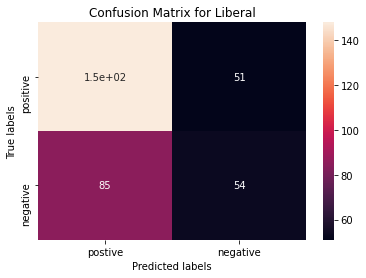

In [ ]:
# slice the dataframe for liberal
liberal_df=new_df[new_df['political_party']=='Liberal']
true_sentiment=liberal_df['sentiment'].values
predicted_sentiment=liberal_df['prediction'].values
# plot confusion matrix 
cm=confusion_matrix(true_sentiment,predicted_sentiment)
ax=plt.subplot()
sns.heatmap(cm,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Liberal'); 
ax.xaxis.set_ticklabels(['postive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative'])

Text(0.5, 1.0, 'True sentiment and predicted sentiment for Liberal Party')

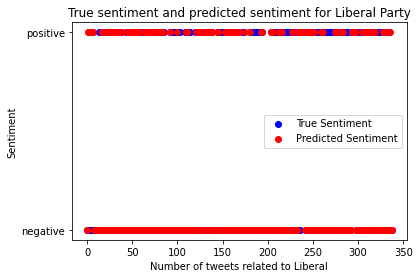

In [ ]:
# print true sentiment and predicted sentiment
plt.scatter(range(len(true_sentiment)),true_sentiment,c='blue',label='True Sentiment')
plt.scatter(range(len(true_sentiment)),predicted_sentiment,c='red',label='Predicted Sentiment')
plt.yticks([0,1],['negative','positive'])
plt.legend()
plt.xlabel('Number of tweets related to Liberal')
plt.ylabel('Sentiment')
plt.title('True sentiment and predicted sentiment for Liberal Party')

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

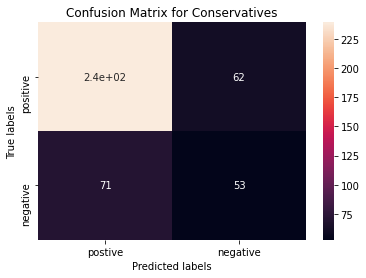

In [ ]:
# slice the dataframe for conservatives
conservative_df=new_df[new_df['political_party']=='Conservatives']
true_sentiment=conservative_df['sentiment'].values
predicted_sentiment=conservative_df['prediction'].values
# plot confusion matrix 
cm=confusion_matrix(true_sentiment,predicted_sentiment)
ax=plt.subplot()
sns.heatmap(cm,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Conservatives'); 
ax.xaxis.set_ticklabels(['postive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative'])

Text(0.5, 1.0, 'True sentiment and predicted sentiment for Conservatives Party')

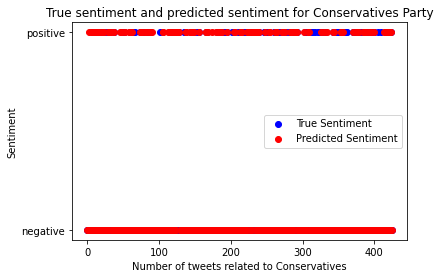

In [ ]:
# print true sentiment and predicted sentiment
plt.scatter(range(len(true_sentiment)),true_sentiment,c='blue',label='True Sentiment')
plt.scatter(range(len(true_sentiment)),predicted_sentiment,c='red',label='Predicted Sentiment')
plt.yticks([0,1],['negative','positive'])
plt.legend()
plt.xlabel('Number of tweets related to Conservatives')
plt.ylabel('Sentiment')
plt.title('True sentiment and predicted sentiment for Conservatives Party')

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

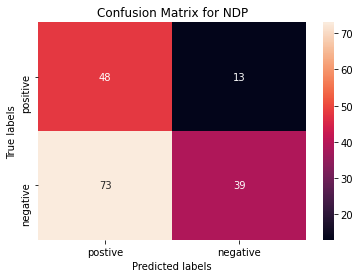

In [ ]:
# slice the dataframe for NDP
NDP_df=new_df[new_df['political_party']=='NDP']
true_sentiment=NDP_df['sentiment'].values
predicted_sentiment=NDP_df['prediction'].values
# plot confusion matrix 
cm=confusion_matrix(true_sentiment,predicted_sentiment)
ax=plt.subplot()
sns.heatmap(cm,annot=True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for NDP'); 
ax.xaxis.set_ticklabels(['postive', 'negative']); ax.yaxis.set_ticklabels(['positive', 'negative'])

Text(0.5, 1.0, 'True sentiment and predicted sentiment for New Democratic Party')

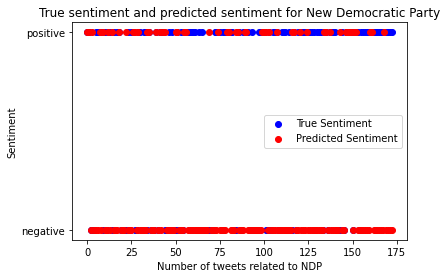

In [ ]:
# print true sentiment and predicted sentiment
plt.scatter(range(len(true_sentiment)),true_sentiment,c='blue',label='True Sentiment')
plt.scatter(range(len(true_sentiment)),predicted_sentiment,c='red',label='Predicted Sentiment')
plt.yticks([0,1],['negative','positive'])
plt.legend()
plt.xlabel('Number of tweets related to NDP')
plt.ylabel('Sentiment')
plt.title('True sentiment and predicted sentiment for New Democratic Party')

From the above analysis, most tweets that have obvious political party are about Liberal party and Conservatives, NDP does not attract too much attention in the election, at least among twitter users. In all the tweets that have clear political party, Conservatives party has the highest number of positive tweets, also Conservatives party has the highest number of tweets about it. It means Conservatives party is pretty "popular" in the election. Also, postive tweets about Liberal party is more than negative tweets about Liberal party, but the difference is small, which means Liberal party is controversial in the election. Although Liberal party won the election, the Conservatives party had more votes and the above analysis does show that the supporters of Conservatives party is more active. 

## **Part 2: predict negative reason for Canadian Election tweets**

The negative reasons are encoded using self-defined encoding. Others, Healthcare, Healthcare and Marijuana are encoded as class 0 since there are only a few negative tweets are about healthcare; Scandal and Tell lies are encoded as class 1 since they are basically the same; Economy is encoded as class 2, Women Reproductive rigut and Racism, Privilege and Separation are encoded as class 3 since they are all about human rights; Climate Problem is encoded as class 4. So there are 5 classes in the multi-class classification problem

In [ ]:
# extract negative tweets
negative_election_tweet_df=election_df[election_df['sentiment']=='negative']
# combine tokens in text
negative_text=[]
for t in negative_election_tweet_df['preprocessed']:
    text=' '.join(t)
    negative_text.append(text)

In [ ]:
# check negative reasons and the count
negative_election_tweet_df['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

In [ ]:
# define negative reason encoding
negative_reason_encoding={'Others':0, 'Scandal':1,'Tell lies':1,'Economy':2,'Women Reproductive right and Racism':3,'Privilege':3,'Separation':3,'Climate Problem':4,
                                                  'Healthcare':0,'Healthcare and Marijuana':0}

In [ ]:
# extract negative target
negative_reason_target=negative_election_tweet_df.loc[:,'negative_reason'].map(negative_reason_encoding)
target=negative_reason_target

In [ ]:
# split data into train and test set
X_train,X_test,y_train,y_test=train_test_split(negative_text,target,test_size=0.3,random_state=23)

In [ ]:
# use TFIDF vectorizer to transform text
tfidf_vectorizer=TfidfVectorizer(max_features=300)
# fit the model with training data
tfidf_vectorizer.fit(X_train)
# transform both training data and testing data using trained model
X_train_tfidf=tfidf_vectorizer.transform(X_train)
X_test_tfidf=tfidf_vectorizer.transform(X_test)

Logistic Regression

5-fold cross-validation for Logistic Regression

In [ ]:
kf=KFold(n_splits=5)
average_accuracy_dict={}
for l1 in [0,0.5,1]:
    for c in [0.01,0.1,1,10]:
        five_fold_accuracy_list=[]
        for train_index,test_index in kf.split(X_train_tfidf):
            X_train_cv,X_test_cv=X_train_tfidf.todense()[train_index],X_train_tfidf.todense()[test_index]
            y_train_cv,y_test_cv=y_train.values[train_index],y_train.values[test_index]
            lr=LogisticRegression(penalty='elasticnet',C=c,l1_ratio=l1,solver='saga',max_iter=2000)
            lr.fit(X_train_cv,y_train_cv)
            prediction=lr.predict(X_test_cv)
            accuracy=accuracy_score(y_test_cv,prediction)
            five_fold_accuracy_list.append(accuracy)
        average_accuracy=sum(five_fold_accuracy_list)/5
        hyperparameter='l1={}, c={}'.format(l1,c)
        average_accuracy_dict[hyperparameter]=round(average_accuracy,3)


In [ ]:
# get the best hyperparameter
print('Best hyperparameter: {} with accuracy {}'.format(max(average_accuracy_dict,key=average_accuracy_dict.get),max(average_accuracy_dict.values())))

Best hyperparameter: l1=1, c=1 with accuracy 0.582


Naive Bayes

5-fold cross-validation for Naive Bayes

In [ ]:
kf=KFold(n_splits=5)
average_accuracy_dict={}
for a in [1,5,10,20,50]:
    five_fold_accuracy_list=[]
    for train_index,test_index in kf.split(X_train_tfidf):
        X_train_cv,X_test_cv=X_train_tfidf.todense()[train_index],X_train_tfidf.todense()[test_index]
        y_train_cv,y_test_cv=y_train.values[train_index],y_train.values[test_index]
        nb=MultinomialNB(alpha=a)
        nb.fit(X_train_cv,y_train_cv)
        prediction=nb.predict(X_test_cv)
        accuracy=accuracy_score(y_test_cv,prediction)
        five_fold_accuracy_list.append(accuracy)
    average_accuracy=sum(five_fold_accuracy_list)/5
    hyperparameter='alpha={}'.format(a)
    average_accuracy_dict[hyperparameter]=round(average_accuracy,3)

In [ ]:
# get the best hyperparameter
print('Best hyperparameter: {} with accuracy {}'.format(max(average_accuracy_dict,key=average_accuracy_dict.get),max(average_accuracy_dict.values())))

Best hyperparameter: alpha=1 with accuracy 0.527


kNN

5-fold cross-validation for kNN

In [ ]:
kf=KFold(n_splits=5)
average_accuracy_dict={}
for n in [4,8,16,32,64,128]:
    for p_value in [1,2]:
        five_fold_accuracy_list=[]
        for train_index,test_index in kf.split(X_train_tfidf):
            X_train_cv,X_test_cv=X_train_tfidf.todense()[train_index],X_train_tfidf.todense()[test_index]
            y_train_cv,y_test_cv=y_train.values[train_index],y_train.values[test_index]
            knn=KNeighborsClassifier(n_neighbors=n,p=p_value)
            knn.fit(X_train_cv,y_train_cv)
            prediction=nb.predict(X_test_cv)
            accuracy=accuracy_score(y_test_cv,prediction)
            five_fold_accuracy_list.append(accuracy)
        average_accuracy=sum(five_fold_accuracy_list)/5
        hyperparameter='k={}, p={}'.format(n,p_value)
        average_accuracy_dict[hyperparameter]=round(average_accuracy,3)

In [ ]:
# get the best hyperparameter
print('Best hyperparameter: {} with accuracy {}'.format(max(average_accuracy_dict,key=average_accuracy_dict.get),max(average_accuracy_dict.values())))

Best hyperparameter: k=4, p=1 with accuracy 0.479


In [ ]:
# train best model with training data and predict on test data
lr=LogisticRegression(penalty='elasticnet',C=1,l1_ratio=1,solver='saga',max_iter=2000)
lr.fit(X_train_tfidf,y_train)
train_prediction=lr.predict(X_train_tfidf)
test_prediction=lr.predict(X_test_tfidf)
train_accuracy=accuracy_score(train_prediction,y_train)
test_accuracy=accuracy_score(test_prediction,y_test)
print('Accuracy of best model on training set: {}'.format(round(train_accuracy,3)))
print('Accuracy of best model on test set: {}'.format(round(test_accuracy,3)))

Accuracy of best model on training set: 0.737
Accuracy of best model on test set: 0.5


In [ ]:
# visualize feature importance 
# get the absolute coefficient
abs_coefs=np.abs(lr.coef_)
# sort the absolute value of coefficient 
sorted_index=np.argsort(abs_coefs)[0][::-1]
# get the index of top 20 feature
top_20_index=sorted_index[:20]
# get feature names from count_vectorizer
feature_name=np.array(count_vectorizer.get_feature_names())
# get top 20 feature names
top_20_feature=feature_name[top_20_index]
# get top 20 feature values
top_20_value=abs_coefs[0][top_20_index]

Text(0.5, 1.0, 'Feature importance in Logistic Regression with TFIDF')

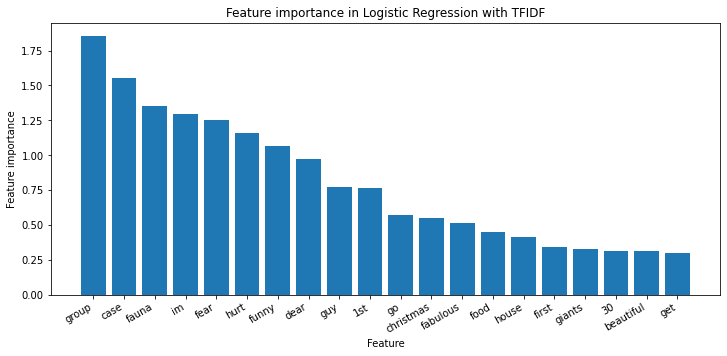

In [ ]:
# create bar plot for feature importance
plt.figure(figsize=(12,5))
plt.bar(height=top_20_value,x=top_20_feature)
plt.xticks(rotation=30,ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature importance')
plt.title('Feature importance in Logistic Regression with TFIDF')

**Why the best model fail to predict the correct negative reason**

There are a few reasons why the best model failed to predict the correct negative reason. The first one is that the best model is overrfitting, from the result above, Logistic Regression with tuned hyperparameter got accuracy of 0.737 on training set and only 0.5 on test set, which is a clear sign of overfitting. Besides, since the number of features used to train the model is small, it is possible that the important features (words) in test set are not being captured in training set and therefore the vectorized features does not provide useful information for test set which makes the model does not perform well on test set. The second reason is that with the self-defined label encoding, most samples are in class 0 and class 1, therefore there are not enough samples in class 2, class 3 and class 4 for the model to learn to distinguish. The third reason might be that the definition of negative reason is ambiguous, it is hard to say if a tweet is a scandal or lie. The example below shows one example where the true negative reason is economy but the model's prediction is scandal or lie.

From the above analysis, to improve the performance of the model, more tweets with negative reasons in class 2, class 3 and class 4 can be collected, and if the negative reasons can be reduced to two or three major classes, the performance of the model might be improved. Also, using more features in the vectorizer can also help to improve the performance and inference ability of the model.

In [ ]:
# check the true label distribution in test set
y_test.value_counts()

1    131
0    113
3     21
4     19
2     18
Name: negative_reason, dtype: int64

In [ ]:
# check the predicted label distribution in test set
print('Predicted class 0: {}'.format(test_prediction[test_prediction==0].shape[0]))
print('Predicted class 1: {}'.format(test_prediction[test_prediction==1].shape[0]))
print('Predicted class 2: {}'.format(test_prediction[test_prediction==2].shape[0]))
print('Predicted class 3: {}'.format(test_prediction[test_prediction==3].shape[0]))
print('Predicted class 4: {}'.format(test_prediction[test_prediction==4].shape[0]))

Predicted class 0: 139
Predicted class 1: 146
Predicted class 2: 5
Predicted class 3: 4
Predicted class 4: 8


In [ ]:
# example
print('Tweet content: {}'.format(X_test[52]))
print('True label: {}'.format(y_test.values[52]))
print('Predicted label: {}'.format(test_prediction[52]))

Tweet content: hey lyin andy facts say otherwise job growth lpc govt greater master harper
True label: 2
Predicted label: 1
